# LeNet-5

In [1]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import matplotlib.pyplot as plt

## Preprocess dataset

### 1. Create Validation Set

In [2]:
train_set_size = 55000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Create Validation set
x_valid, y_valid = x_train[train_set_size:], y_train[train_set_size:]
x_train, y_train = x_train[:train_set_size], y_train[:train_set_size]

### 2. Reshape X, Y
The input image is of shape $m \times 28 \times 28$, we need to reshape it into a size of $m \times 28 \times 28 \times 1$.
The output lables are stored as a single vector of size $m$, We need to have a seperate output vector for each example, i.e., of shape $m \times 1$

In [3]:
# Reshape x from 28x28 to 28x28x1
x_train = x_train.reshape(-1, 28,28,1)
x_valid = x_valid.reshape(-1, 28,28,1)
x_test = x_test.reshape(-1, 28,28,1)

# Convert each element to an array; i.e., from (5000,) to (5000,1)
y_train = y_train.reshape(-1,1)
y_valid = y_valid.reshape(-1,1)
y_test = y_test.reshape(-1,1)

### 3.Create One-Hot Vectors

In [4]:
# Convert to One-Hot Vectors
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(y_train)
y_train = one_hot_encoder.transform(y_train)
y_valid = one_hot_encoder.transform(y_valid)
y_test = one_hot_encoder.transform(y_test)
#print(y_train[0], y_test[0], y_valid[0])

print("Train set size: ",x_train.shape, y_train.shape )
print("Valid set size: ", x_valid.shape, y_valid.shape)
print("Test set size: ", x_test.shape, y_test.shape)

Train set size:  (55000, 28, 28, 1) (55000, 10)
Valid set size:  (5000, 28, 28, 1) (5000, 10)
Test set size:  (10000, 28, 28, 1) (10000, 10)


### 4. Create TF dataset and Resize image
Create a tf dataset and then resize image from $28 \times 28$ to $32 \times 32$ 

In [12]:
# Create Dataset
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def resize(image, label):
    """Resize the image to 32x32x1
    """
    image = tf.image.resize_with_pad(image, 32, 32, method ='bilinear')
    #print(image.shape)
    return image, label

train_ready = train.map(resize)
train_ready = train_ready.cache().shuffle(buffer_size=250).batch(64)

valid_ready = valid.map(resize)
valid_ready = valid_ready.cache().shuffle(buffer_size=250).batch(64)

test_ready = test.map(resize)
test_ready = test_ready.cache().shuffle(buffer_size=250).batch(64)

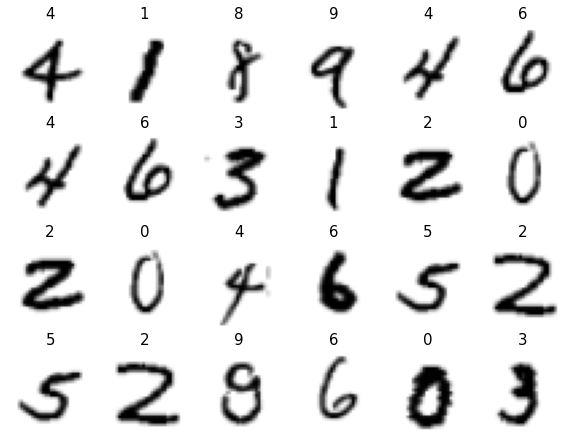

In [17]:
def view_image(dataset, grid_size=(4,6)):
    fig, ax = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 16))
    fig.subplots_adjust(hspace=-0.8, wspace=0.1)
    
    for x_batch, y_batch in dataset.take(1):
    # This returns a batch, so select the first example from the batch
        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                index = i*grid_size[0]+j
                ax[i,j].imshow(np.array(x_batch[index]), cmap='binary')
                ax[i,j].axis('off')
                ax[i,j].set_title(int(tf.math.argmax(y_batch[index])), fontsize= 15)

view_image(train_ready)

### LeNet-5 Architecture

LetNet-5 is a Feed Forward Convolutional Neural Network Architecture proposed by Yaan LeCun in 1989. It consists of a Convolutional layer - which picked up general features from the image, and it was followed by an Average Pooling layer - which achieved invariance to rotation, pixel desnity etc,. The same pair of layers were repeated and we feed the outputs to a few dense layers and finally a softmax layer was used for classification.

![](./assets/le-net.jpg)

In [18]:
def get_leNet_model():
    inputs = tfl.Input(shape=(32,32,1))

    conv1 = tfl.Conv2D(filters=6, kernel_size=(5,5))(inputs)
    conv1 = tfl.AveragePooling2D(pool_size=(2,2), strides=(2,2))(conv1)

    conv2 = tfl.Conv2D(filters=16, kernel_size=(5,5))(conv1)
    conv2 = tfl.AveragePooling2D(pool_size=(2,2), strides=(2,2))(conv2)

    flatten = tfl.Flatten()(conv2)

    dense = tfl.Dense(units=120, activation='relu')(flatten)
    dense = tfl.Dense(units=84, activation='relu')(dense)

    output = tfl.Dense(units=10, activation='softmax')(dense)

    return tf.keras.Model(inputs=inputs, outputs=output)

leNet = get_leNet_model()

In [20]:
early_stopping_cb = tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True)

leNet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
leNet.summary()

TypeError: __init__() missing 1 required positional argument: 'filepath'

In [34]:
history = leNet.fit(train_ready,
                    validation_data=valid_ready,
                    validation_steps=10,
                    epochs=50,
                    callbacks=[early_stopping_cb])

# Save model and history
leNet.save('lenet.h5')
np.save("history.npy", history.history)

Epoch 1/50
 15/860 [..............................] - ETA: 54s - loss: 18.7589 - accuracy: 0.3142

860/860 [==============================] - 61s 70ms/step - loss: 1.5753 - accuracy: 0.8483 - val_loss: 0.1574 - val_accuracy: 0.9516

Epoch 00001: val_loss improved from inf to 0.15745, saving model to leNet.h5
Epoch 2/50
860/860 [==============================] - 59s 68ms/step - loss: 0.1576 - accuracy: 0.9545 - val_loss: 0.0913 - val_accuracy: 0.9672

Epoch 00002: val_loss improved from 0.15745 to 0.09125, saving model to leNet.h5
Epoch 3/50
860/860 [==============================] - 58s 68ms/step - loss: 0.1162 - accuracy: 0.9641 - val_loss: 0.1163 - val_accuracy: 0.9594

Epoch 00003: val_loss did not improve from 0.09125
Epoch 4/50
860/860 [==============================] - 59s 68ms/step - loss: 0.1013 - accuracy: 0.9696 - val_loss: 0.0978 - val_accuracy: 0.9609

Epoch 00004: val_loss did not improve from 0.09125
Epoch 5/50
860/860 [==============================] - 60s 69ms/step - loss: 0.0908 - accuracy: 0.9721 - val_loss: 0.1221 - val_accuracy: 0.9688

Epoch 00005: val_loss did 

KeyboardInterrupt: 

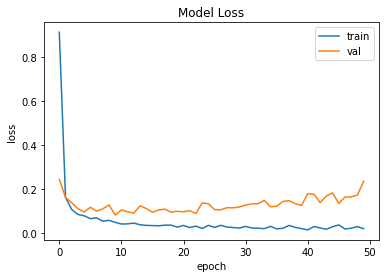

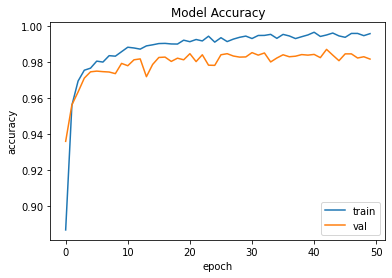

In [30]:
#history=np.load('history.npy',allow_pickle='TRUE').item()

plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()
plt.show()

plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

### Evalutate on Test Set

In [73]:
evaluate = leNet.evaluate(test_ready)

157/157 [==============================] - 2s 13ms/step - loss: 0.1376 - accuracy: 0.9675


Test Set Accuracy: 0.9674999713897705


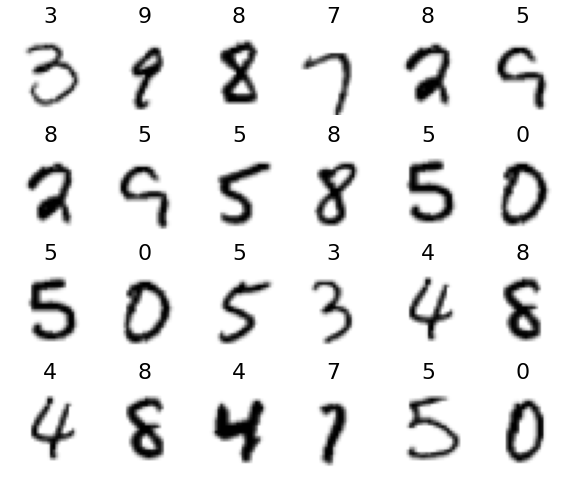

In [76]:
display = (4,6)
fig, ax = plt.subplots(display[0], display[1], figsize=(10, 12))
fig.subplots_adjust(hspace=-0.6, wspace=0.1)
print(f'Test Set Accuracy: {evaluate[1]}')

for x, y in test_ready.take(1):
    pred = leNet.predict(x)
    
    for i in range(display[0]):
        for j in range(display[1]):
            index = i*display[0]+j
            ax[i,j].imshow(np.array(x[index]), cmap='binary')
            ax[i,j].axis('off')
            ax[i,j].set_title(int(tf.math.argmax(pred[index])), fontsize= 22)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=766f6aef-919b-4868-bd8f-8ef54f6f832e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>